In [3]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from numba import jit as njit

In [4]:
@njit(nopython=True)
def bitreverse(n: int, num_bits: int) -> int:
    x = 0
    for i in range(num_bits):
        x |= ((n >> i) & 0x1) << ((num_bits - i) - 1)
        #n >>= 1
    return x

In [5]:
assert bin(bitreverse(int('0b0111', 2), 4)) == bin(int('0b1110', 2))
assert bin(bitreverse(int('0b101001', 2), 6)) == bin(int('0b100101', 2))

In [6]:
@njit(nopython=True)
def shuffle_coeff(x: npt.NDArray[np.float64], y: npt.NDArray[np.cdouble]):
    bits = int(np.log2(len(x)))
    for i in range(len(x)):
        y[i] = x[bitreverse(i, bits)] # + 0j
    return y

In [7]:
t = np.array([10, 11, 12, 13], dtype=np.float64)
ts = np.empty(4, dtype=np.cdouble)
shuffle_coeff(t, ts)
assert ts[0] == 10 + 0j
assert ts[1] == 12 + 0j
assert ts[2] == 11 + 0j
assert ts[3] == 13 + 0j
print

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [71]:
@njit(nopython=True)
def myfft(x: npt.NDArray[np.float64]) -> npt.NDArray[np.cdouble]:
    N = len(x)
    y = np.zeros(N, dtype = np.cdouble)
    shuffle_coeff(x, y)
    levels = int(np.log2(N))
    for l in range(1, levels + 1):
        stride = 1 << l # 
        s2 = stride >> 1
        wm = np.exp(-1j * np.pi / s2)
        w = 1. + 0j
        for s in range(s2):
            for k in range(s, N, stride):
                #u = y[k]
                ks2 = k+s2
                t = w * y[ks2]
                y[ks2] = y[k] - t
                y[k] += t            
            w *= wm
    return y  
        

In [7]:
x = np.random.random(8192)
assert np.allclose(myfft(x), np.fft.fft(x))

In [9]:
%timeit myfft(x)
%timeit np.fft.fft(x)

120 µs ± 573 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
56.3 µs ± 555 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [79]:
@njit(nopython=True)
def myfft2(x: npt.NDArray[np.float64]) -> npt.NDArray[np.cdouble]:
    N = len(x)
    y = np.zeros(N, dtype = np.cdouble)
    shuffle_coeff(x, y)
    levels = int(np.log2(N))
    for l in range(1, levels + 1):
        stride = 1 << l # 
        s2 = stride >> 1
        wm = np.exp(-1j * np.pi / s2) # s2 == stride/2 --> np.exp(-2j*np.pi/s2) 
        w = 1. + 0j
        for s in range(s2):
            for k in range(s, N, stride):
                u = y[k]
                y[k] = u + w * y[k+stride//2]
                y[k + stride // 2] = u - w * y[k+stride//2]
            w *= wm
        print(y)
    return y  

In [81]:
x = np.arange(1,17) #np.random.random(16)
assert np.allclose(myfft2(x), np.fft.fft(x))

[10.+0.j -8.+0.j 18.+0.j -8.+0.j 14.+0.j -8.+0.j 22.+0.j -8.+0.j 12.+0.j
 -8.+0.j 20.+0.j -8.+0.j 16.+0.j -8.+0.j 24.+0.j -8.+0.j]
[28.+0.j -8.+8.j -8.+0.j -8.-8.j 36.+0.j -8.+8.j -8.+0.j -8.-8.j 32.+0.j
 -8.+8.j -8.+0.j -8.-8.j 40.+0.j -8.+8.j -8.+0.j -8.-8.j]
[64. +0.j        -8.+19.3137085j -8. +8.j        -8. +3.3137085j
 -8. +0.j        -8. -3.3137085j -8. -8.j        -8.-19.3137085j
 72. +0.j        -8.+19.3137085j -8. +8.j        -8. +3.3137085j
 -8. +0.j        -8. -3.3137085j -8. -8.j        -8.-19.3137085j]
[136. +0.j          -8.+40.21871594j  -8.+19.3137085j   -8.+11.9728461j
  -8. +8.j          -8. +5.3454291j   -8. +3.3137085j   -8. +1.59129894j
  -8. +0.j          -8. -1.59129894j  -8. -3.3137085j   -8. -5.3454291j
  -8. -8.j          -8.-11.9728461j   -8.-19.3137085j   -8.-40.21871594j]


  1 0 0 <object type:complex128>
  1 0 2 <object type:complex128>
  1 0 4 <object type:complex128>
  1 0 6 <object type:complex128>
  1 0 8 <object type:complex128>
  1 0 10 <object type:complex128>
  1 0 12 <object type:complex128>
  1 0 14 <object type:complex128>
   2 0 0 <object type:complex128>
   2 0 4 <object type:complex128>
   2 0 8 <object type:complex128>
   2 0 12 <object type:complex128>
   2 1 1 <object type:complex128>
   2 1 5 <object type:complex128>
   2 1 9 <object type:complex128>
   2 1 13 <object type:complex128>
    3 0 0 <object type:complex128>
    3 0 8 <object type:complex128>
    3 1 1 <object type:complex128>
    3 1 9 <object type:complex128>
    3 2 2 <object type:complex128>
    3 2 10 <object type:complex128>
    3 3 3 <object type:complex128>
    3 3 11 <object type:complex128>
     4 0 0 <object type:complex128>
     4 1 1 <object type:complex128>
     4 2 2 <object type:complex128>
     4 3 3 <object type:complex128>
     4 4 4 <object type:complex12

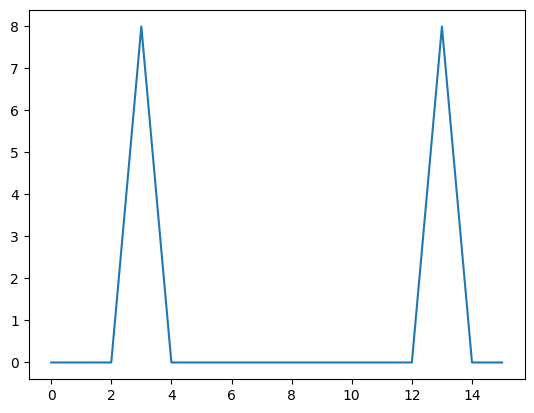

In [41]:
y = np.cos(2*np.pi*3*np.arange(0., 1., 1./16))
plt.plot(np.abs(myfft2(y)))
#plt.plot(np.abs(np.fft.fft(y)))

In [62]:
x = np.random.random(8192)
%timeit myfft2(x)
%timeit np.fft.fft(x)

230 µs ± 68.6 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
55.9 µs ± 618 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


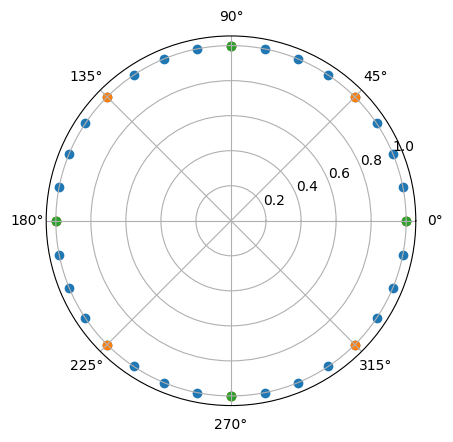

In [76]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
f = np.exp(-2j*np.pi*np.arange(0,1,1/32))
ax.scatter(np.angle(f), np.abs(f))
f2 = np.exp(-2j*np.pi*np.arange(0,1,1/8))
ax.scatter(np.angle(f2), np.abs(f2))
f3 = np.exp(-2j*np.pi*np.arange(0,1,1/4))
ax.scatter(np.angle(f3), np.abs(f3))
# ax.set_rmax(2)
# ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
# ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)